In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas_datareader import data, wb
import datetime

In [2]:
# set date range
start = datetime.datetime(1990, 1, 1)
end = datetime.datetime(2013, 1, 27)

In [3]:
# load ticker data
f = data.DataReader("^GSPC", 'yahoo', start, end)
px = pd.ewma(f.Close, halflife=1)

Get greatest market losses over the next X days for each date

In [4]:
# create df of lagged returns
px = pd.DataFrame(px)
for i in range(1, 180):
    px[i] = px[0].shift(-1 * i)
r = (px.div(px[0], axis='index')
     .applymap(lambda x: x - 1.))

In [5]:
# create triangle mask to find max losses over a period of time
def get_max_drop(per, ret):
    m = np.ones([per,per],dtype='bool')
    m[np.triu_indices(per)] = False
    m = np.fliplr(m)
    return ret.ix[:per,1:per].mask(m).min().min()   

In [6]:
# build df of max losses over multiple ranges
drops = {}
for per in [22 * i for i in (1,3,6)]:
    drops[per] = pd.Series(data=[get_max_drop(per, r.ix[i:,:]) for i in range(0,r.shape[0]-per)], 
                           index=r.index[:r.shape[0]-per])
drops = pd.DataFrame(drops)

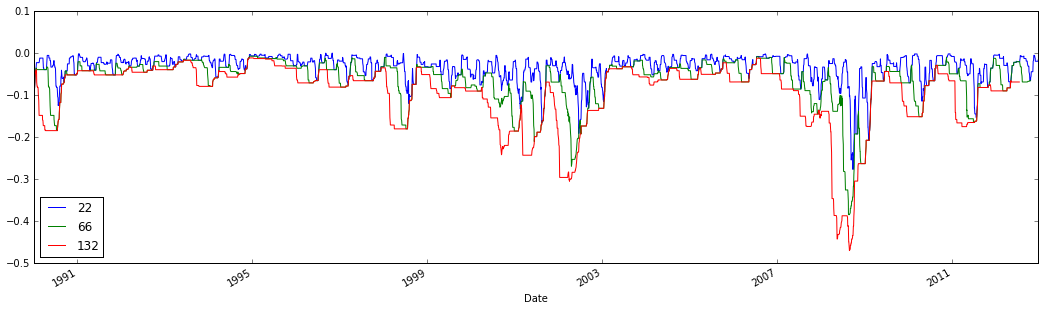

In [7]:
drops.plot(figsize=[18,5])

## pandas datasources

In [12]:
gdp = data.DataReader("GDP", "fred", start, end)

In [13]:
fred = data.DataReader(["GDP", "CPIAUCSL", "CPILFESL", "VIXCLS", "VXVCLS", "AAA", "DTB3"], "fred", start, end)

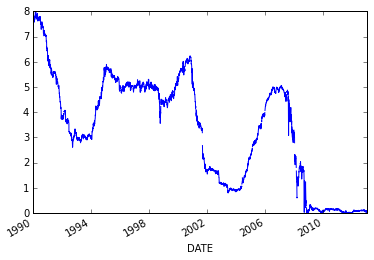

In [14]:
fred["DTB3"].plot()

In [15]:
data.DataReader("5_Industry_Portfolios", "famafrench")

HTTPError: HTTP Error 404: Not Found